In [50]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report,log_loss

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import History

from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


import nltk

nltk.download('punkt')     # Tokenizer
nltk.download('punkt_tab')
nltk.download('stopwords') # Stopwords
nltk.download('wordnet')   # Lemmatizer

import numpy as np


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
!ls /

bin			    dev    lib64		     opt		run   tools
boot			    etc    libx32		     proc		sbin  usr
content			    home   media		     python-apt		srv   var
cuda-keyring_1.0-1_all.deb  lib    mnt			     python-apt.tar.xz	sys
datalab			    lib32  NGC-DL-CONTAINER-LICENSE  root		tmp


In [3]:
#unzip file
import zipfile

# Replace 'your_file.zip' with the name of your uploaded zip file
zip_file_path = 'train.csv.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/final_project/')


In [4]:
# List the extracted files to verify
import os
os.listdir('/final_project/')

['train.csv']

In [5]:
#look at train csv file
train_df=pd.read_csv('/final_project/train.csv')

In [158]:
train_df.head()

,Id,Review,Rating
0,0,Very good value and a great tv very happy and ...,5
1,1,After 6 month still can't access my account,3
2,2,I couldn't make an official review on a produc...,1
3,3,"Fantastic! Extremely easy to use website, fant...",5
4,4,So far annoyed as hell with this bt monthly pa...,1


In [159]:
train_df.shape

(60000, 3)

In [160]:
#get max and min of rating column
max_rating = train_df['Rating'].max()
min_rating = train_df['Rating'].min()
print(max_rating)
print(min_rating)

5
1


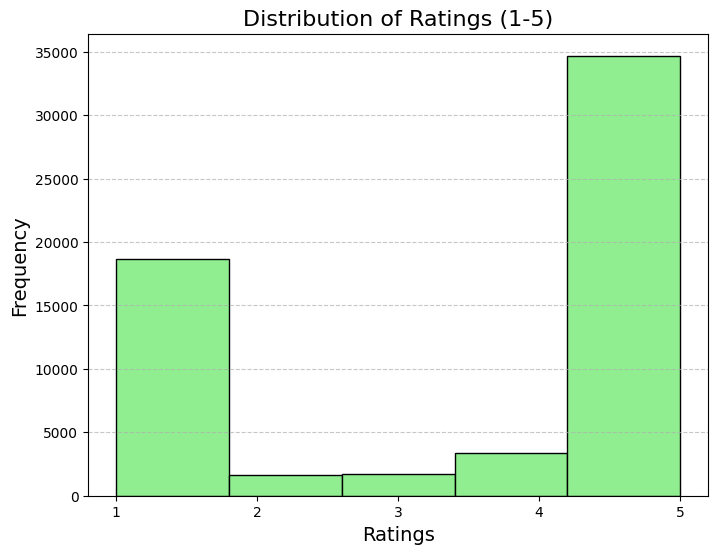

In [161]:
# Create a histogram for the Rating column
plt.figure(figsize=(8, 6))
plt.hist(train_df['Rating'], bins=5, range=(1, 5), edgecolor='black', color='lightgreen')
plt.title('Distribution of Ratings (1-5)', fontsize=16)
plt.xlabel('Ratings', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks([1, 2, 3, 4, 5])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [53]:
#Data preprocessing

In [54]:

def sentiment_class(x):
  if x in (1,2):
    return 'negative'
  elif x == 3:
    return 'neutral'
  else:
    return 'positive'

train_df['Sentiment'] = train_df['Rating'].apply(sentiment_class)
train_df['Sentiment'].value_counts()

,count
Sentiment,
positive,38029
negative,20292


In [7]:
#Drop review if sentiment is netural
train_df = train_df[train_df['Sentiment']!= 'neutral']

In [8]:
train_df = train_df.reset_index()

In [9]:
np.random.seed(0)
indices = np.arange(train_df.shape[0])
shuffled_indices = np.random.permutation(indices)
reviews_df = train_df.reindex(shuffled_indices)

X = train_df[['Review', 'Rating']]
y = train_df['Sentiment']

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1234)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1234)

In [11]:
df_balanced = pd.concat(
    [X_train, y_train],
    axis=1)


temp_positive = df_balanced[df_balanced.Sentiment == 'positive'].sample(
    n=12000,
    replace=False
)

temp_negative = df_balanced[df_balanced.Sentiment == 'negative'].sample(
    n=12000,
    replace=False
)

df_balanced = pd.concat(
    [temp_positive, temp_negative],
    axis=0)

# shuffle df_balanced
df_balanced = df_balanced.sample(frac=1) # frac=1 retains all the data
df_balanced.reset_index(drop=True, inplace=True) # reset index

print('After preprocessing, our data contains', df_balanced.shape[0], 'reviews.')

After preprocessing, our data contains 24000 reviews.


In [12]:
#Transform categorical y variable to be binary numerical format
# (0= negative, positive = 1)
X_train = df_balanced['Review']
y_train = df_balanced['Sentiment']
y_train = np.where(y_train.eq('positive'), 1, 0)

X_val = X_val['Review']
y_val = np.where(y_val.eq('positive'), 1, 0)

X_test = X_test['Review']
y_test = np.where(y_test.eq('positive'), 1, 0)

In [13]:
# remove punctuation and other non-letter characters
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           text)
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', ''))

    return text

In [14]:
#Apply data preprocessing to all input datasets
X_train = X_train.apply(preprocessor)
X_val = X_val.apply(str).apply(preprocessor)
X_test = X_test.apply(str).apply(preprocessor)

In [15]:
vectorizer = TfidfVectorizer(max_features=1000)  # Limit to 1000 features for simplicity

# Fit and transform the reviews into numerical features
X_train_vec = vectorizer.fit_transform(np.array(X_train)).toarray()
X_val_vec = vectorizer.fit_transform(np.array(X_val)).toarray() # transform validation data
X_test_vec = vectorizer.fit_transform(np.array(X_test)).toarray() # transform test data

In [16]:
X_test_vec.shape

(11665, 1000)

In [17]:
train_df.head()

,index,Id,Review,Rating,Sentiment
0,0,0,Very good value and a great tv very happy and ...,5,positive
1,2,2,I couldn't make an official review on a produc...,1,negative
2,3,3,"Fantastic! Extremely easy to use website, fant...",5,positive
3,4,4,So far annoyed as hell with this bt monthly pa...,1,negative
4,5,5,Correct replacement delivered on time now my v...,5,positive


In [52]:
# Logistic Regression Model (sklean library)

In [18]:
log_reg = LogisticRegression(max_iter=100)
log_reg.fit(X_train_vec, y_train)
y_pred_log_reg = log_reg.predict(X_test_vec)
print("Classification Report:")
print(classification_report(y_test, y_pred_log_reg))
print(f"Logistic Regression Model Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.73      0.60      4088
           1       0.81      0.63      0.71      7577

    accuracy                           0.66     11665
   macro avg       0.66      0.68      0.65     11665
weighted avg       0.71      0.66      0.67     11665

Logistic Regression Model Accuracy: 0.6628


In [19]:
y_train_pred = log_reg.predict(X_train_vec)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {train_accuracy:.4f}")

Train Accuracy: 0.9668


In [20]:
#validation accuracy
y_val_pred = log_reg.predict(X_val_vec)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.6796124828532236
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.79      0.64      4107
           1       0.85      0.62      0.71      7557

    accuracy                           0.68     11664
   macro avg       0.69      0.71      0.67     11664
weighted avg       0.74      0.68      0.69     11664



In [33]:
#test accuracy
log_accuracy=accuracy_score(y_test, y_pred_log_reg)
log_accuracy

0.6627518216888126

In [24]:
#Train,test and test loss
y_train_pred = log_reg.predict_proba(X_train_vec)[:, 1]
train_loss = log_loss(y_train, y_train_pred)
print(f"Train Loss: {train_loss:.4f}")

y_test_pred = log_reg.predict_proba(X_test_vec)[:, 1]
test_loss = log_loss(y_test, y_test_pred)
print(f"Test Loss: {test_loss:.4f}")

Train Loss: 0.1112
Test Loss: 0.6358


In [49]:
#Random Forest Classifier

In [31]:
rf_model = RandomForestClassifier(n_estimators=30, max_depth=20,random_state=42)

# Train the model
rf_model.fit(X_train_vec, y_train)

# Predict on test
y_pred_rf = rf_model.predict(X_test_vec)

train_accuracy=rf_model.score(X_train_vec,y_train)
print(f"train Accuracy : {train_accuracy}")
# Test classification report and accuracy for model
print("\nRandom Forest - Test Classification Report:")
print(classification_report(y_test, y_pred_rf))
rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test_vec))
print(f"Random Forest Test Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

train Accuracy : 0.9635416666666666

Random Forest - Test Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.65      0.69      4088
           1       0.82      0.88      0.85      7577

    accuracy                           0.80     11665
   macro avg       0.78      0.76      0.77     11665
weighted avg       0.79      0.80      0.79     11665

Random Forest Test Accuracy: 0.7979


In [30]:
# validation classification report and accuracy for model
y_pred_val = rf_model.predict(X_val_vec)
print("\nRandom Forest - Validation Classification Report:")
print(classification_report(y_val, y_pred_val))
rf_accuracy = accuracy_score(y_val, rf_model.predict(X_val_vec))
print(f"Random Validation Forest Accuracy: {accuracy_score(y_val, y_pred_val):.4f}")


Random Forest - Validation Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.51      0.60      4107
           1       0.77      0.90      0.83      7557

    accuracy                           0.76     11664
   macro avg       0.75      0.71      0.72     11664
weighted avg       0.76      0.76      0.75     11664

Random Validation Forest Accuracy: 0.7623


In [179]:
# Print the number of trees in the Random Forest
print(f"Number of trees: {len(rf_model.estimators_)}")

# Print the depth of each tree
tree_depths = [tree.tree_.max_depth for tree in rf_model.estimators_]
print(f"Maximum depth of trees: {max(tree_depths)}")

# Print the number of features the model used
print(f"Number of features used: {X_train_vec.shape[1]}")

# Print the class labels the model was trained on
print(f"Class labels: {rf_model.classes_}")

Number of trees: 30
Maximum depth of trees: 20
Number of features used: 1000
Class labels: [0 1]


In [26]:
#Test accuracy
rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test_vec))

In [27]:
rf_accuracy

0.7978568366909559

In [32]:
#Train los
y_train_pred = rf_model.predict_proba(X_train_vec)[:, 1]
train_loss = log_loss(y_train, y_train_pred)
print(f"Train Loss: {train_loss:.4f}")

#Test loss
y_test_pred = rf_model.predict_proba(X_test_vec)[:, 1]
test_loss = log_loss(y_test, y_test_pred)
print(f"Test Loss: {test_loss:.4f}")

Train Loss: 0.1924
Test Loss: 0.4685


In [48]:
#LSTM MODEL

In [33]:
X_text=train_df["Review"].to_list()

In [34]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_text)
# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 37466


In [35]:
lengths = [len(seq.split()) for seq in X_text]
print(f"Min length: {min(lengths)}, Max length: {max(lengths)}, Average length: {np.mean(lengths)}")

Min length: 1, Max length: 1439, Average length: 56.28584900807599


In [36]:
#LSTM Model params
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 100
BATCH_SIZE = 16
EPOCHS = 2

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(np.array(X_train))
X_sequences = tokenizer.texts_to_sequences(np.array(X_train))
X_pad = pad_sequences(X_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_val_sequences = tokenizer.texts_to_sequences(np.array(X_val))
X_val_pad=pad_sequences(X_val_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [37]:
X_test_sequences = tokenizer.texts_to_sequences(np.array(X_test))
X_test_pad=pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [38]:
X_train.shape

(24000,)

In [39]:
model = Sequential()
model.add(Embedding(input_dim=MAX_VOCAB_SIZE,
                    output_dim=EMBEDDING_DIM,
                    input_length=MAX_SEQUENCE_LENGTH))


model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(np.array(X_pad), np.array(y_train),
                    epochs=5,
                    batch_size=32,
                    validation_data=(np.array(X_val_pad), np.array(y_val)))


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


750/750 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - accuracy: 0.8812 - loss: 0.2768 - val_accuracy: 0.9604 - val_loss: 0.1142
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - accuracy: 0.9712 - loss: 0.0870 - val_accuracy: 0.9606 - val_loss: 0.1120
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.9795 - loss: 0.0626 - val_accuracy: 0.9570 - val_loss: 0.1385
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.9850 - loss: 0.0477 - val_accuracy: 0.9535 - val_loss: 0.1420
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - accuracy: 0.9868 - loss: 0.0400 - val_accuracy: 0.9541 - val_loss: 0.1592


In [40]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (32, 50, 100)               │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (32, 64)                    │          42,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 1)                     │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,126,917 (11.93 MB)

 Trainable params: 1,042,305 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,084,612 (7.95 MB)

In [41]:
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9529


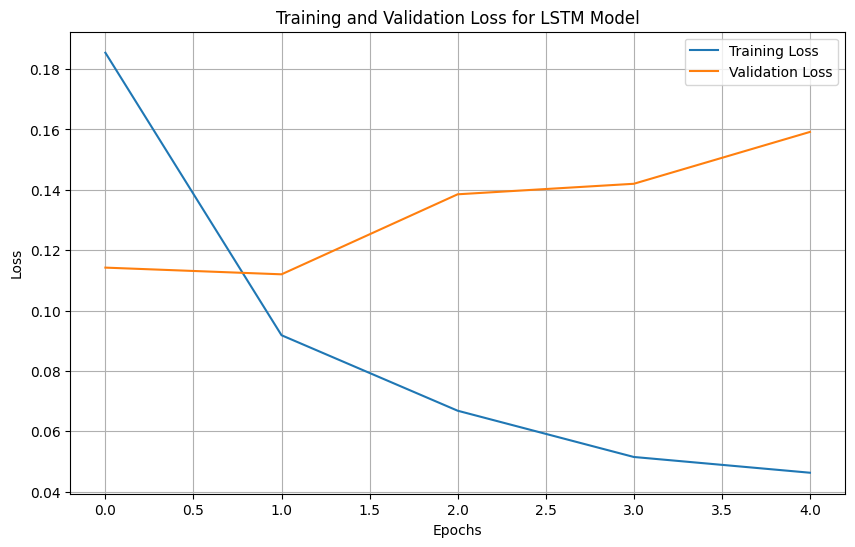

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

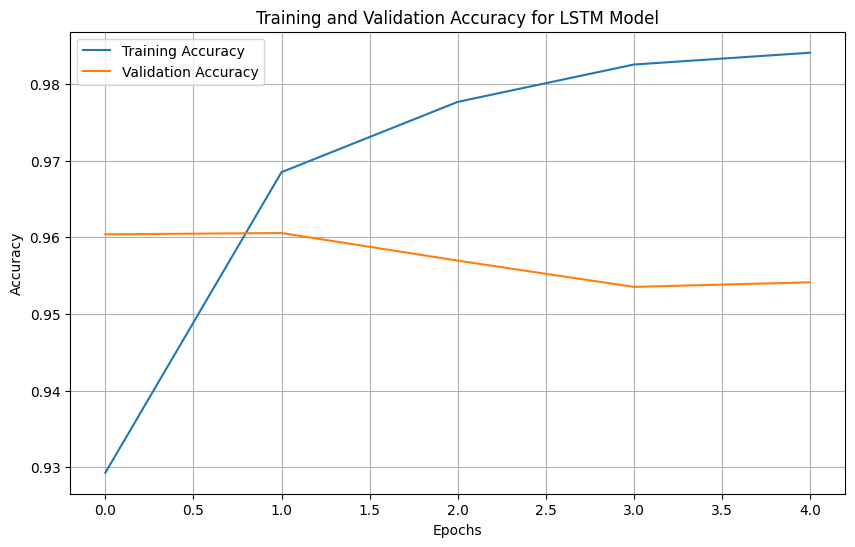

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy for LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
train_accuracy_last_epoch = history.history['accuracy'][-1]
val_accuracy_last_epoch = history.history['val_accuracy'][-1]
print(f"Training Accuracy at Last Epoch: {train_accuracy_last_epoch:.4f}")
print(f"Validation Accuracy at Last Epoch: {val_accuracy_last_epoch:.4f}")

Training Accuracy at Last Epoch: 0.9841
Validation Accuracy at Last Epoch: 0.9541


In [46]:
#Train loss
train_loss = history.history['loss'][-1]
print(f"Train Loss: {train_loss:.4f}")

Train Loss: 0.0463


In [47]:
#Test loss
y_test_pred = model.predict(np.array(X_test_pad))
test_log_loss = log_loss(y_test, y_test_pred)
print(f"Test Loss: {test_log_loss:.4f}")

365/365 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
Test Loss: 0.1619


In [ ]:
#Run 3 models on glass door company data

In [182]:
#Glass Door Company Reviews
glassdoor_company = pd.read_csv('Final_Company_Reviews.csv')
glassdoor_company = glassdoor_company[glassdoor_company['Star Rating'] != 3]
glassdoor_company['Sentiment'] = glassdoor_company['Star Rating'].apply(lambda x: 0 if x==1 else 1)
glassdoor_company_X = glassdoor_company['Review Text']
glassdoor_company_y = glassdoor_company['Sentiment']

In [183]:
#vectorize data and run baseline model
company_test_vec = vectorizer.transform(glassdoor_company_X)
log_pred_company= log_reg.predict(company_test_vec)
company_ratings=glassdoor_company_y.to_list()
company_reviews=glassdoor_company_X.to_list()

In [184]:
#baseline model classification report
print("Classification Report:")
print(classification_report(company_ratings,log_pred_company))
print(f"Logistic Regression Model Accuracy: {accuracy_score(company_ratings,log_pred_company):.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.75      0.86         4

    accuracy                           0.88         8
   macro avg       0.90      0.88      0.87         8
weighted avg       0.90      0.88      0.87         8

Logistic Regression Model Accuracy: 0.8750


In [185]:
#random forest on glass door reviews
random_forest_company = rf_model.predict(company_test_vec)
print("\nRandom Forest - Classification Report:")
print(classification_report(company_ratings, random_forest_company))
rf_accuracy = accuracy_score(company_ratings, rf_model.predict(company_test_vec))
print(f"Random Forest Accuracy: {accuracy_score(company_ratings, random_forest_company):.4f}")


Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.75      0.75      0.75         4

    accuracy                           0.75         8
   macro avg       0.75      0.75      0.75         8
weighted avg       0.75      0.75      0.75         8

Random Forest Accuracy: 0.7500


In [186]:
#LSTM on Glass Door Company Reveiws
company_test_sequences = tokenizer.texts_to_sequences(np.array(glassdoor_company_X))
company_test_pad=pad_sequences(company_test_sequences)

In [187]:
company_loss, company_accuracy = model.evaluate(company_test_pad,np.array(company_ratings), verbose=0)
print(f"Test Accuracy: {company_accuracy:.4f}")

Test Accuracy: 0.6250
